In [68]:

import pandas as pd
import numpy as np
import warnings



import re
import os
import json

import plotly.express as px

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, log_loss, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import KNNImputer

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(10,5)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import shap
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV

import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [28]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('tested.csv')
entire_df = pd.concat([train_df, test_df], axis = 0)

Text(0.5, 1.0, 'Test Dataset: Missing Values')

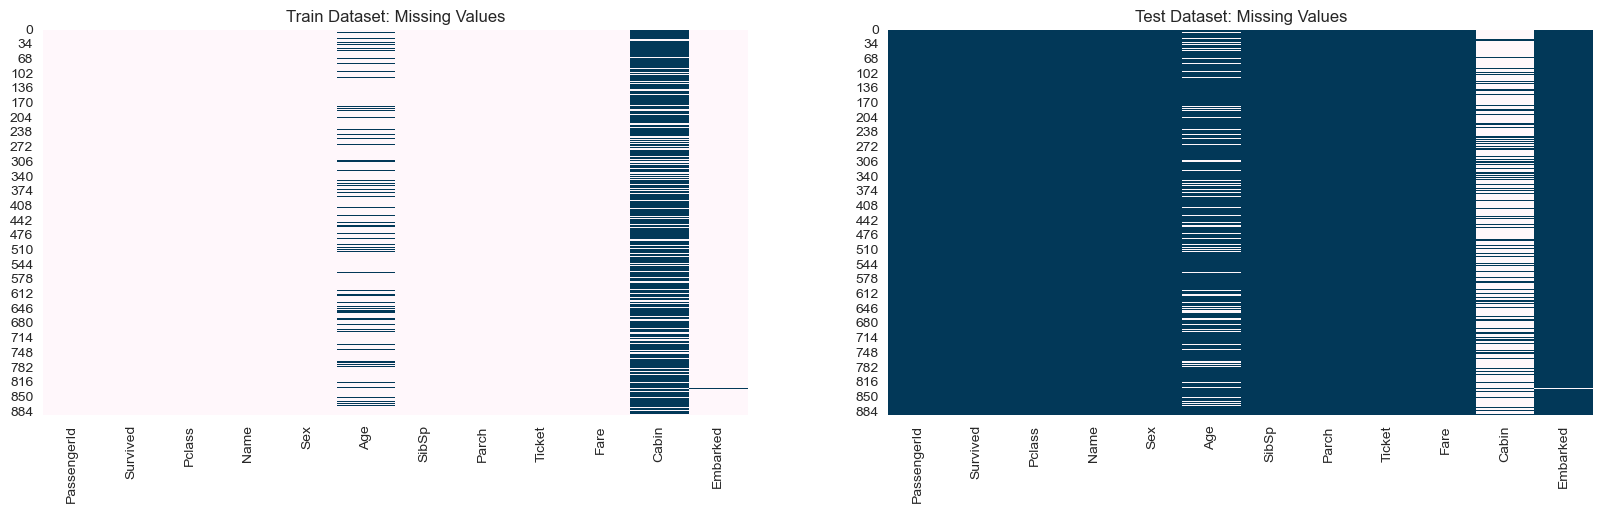

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu',ax=ax[0])
ax[0].set_title('Train Dataset: Missing Values')
sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu_r',ax=ax[1])
ax[1].set_title('Test Dataset: Missing Values')

In [30]:
# Show missing values for the entire dataset
def missing_tbl(df):
    tbl = pd.DataFrame()
    
    tbl['Column'] = df.columns
    tbl['Missing'] = [df[col].isnull().sum() for col in df.columns]
    tbl['Percentage'] = [round((df[col].isnull().sum() / df.shape[0])*100, 2) for col in df.columns]
    return tbl


missing_tbl(entire_df)

,Column,Missing,Percentage
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
5,Age,263,20.09
6,SibSp,0,0.00
7,Parch,0,0.00
8,Ticket,0,0.00
9,Fare,1,0.08


Text(0.5, 1.0, 'Age Distribution')

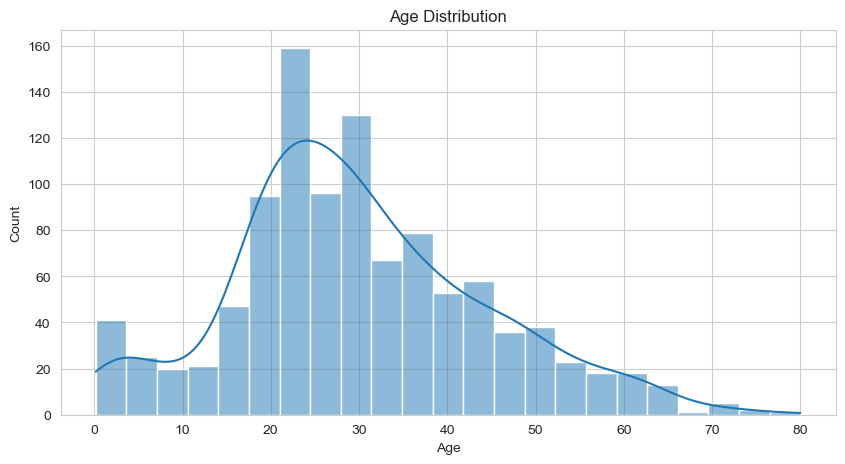

In [22]:
sns.histplot(data=entire_df['Age'], kde=True)
plt.title('Age Distribution')

In [31]:
# Create Title column by extracting title from Name column
def create_title(df):
    df = df.copy()
    df['Title'] = df['Name'].str.split(', ', expand=True)[1]
    df['Title'] = df['Title'].str.split('.', expand=True)[0]
    return df


entire_df = create_title(entire_df)

In [32]:
# Standardized Title column
def standardized_title(df):
    df = df.copy()
    
    # Unmarried woman
    unmarried_w = ['Mlle', 'Ms']
    for uw in unmarried_w:
        df['Title'].replace({uw : 'Miss'}, inplace=True)
    
    # Married woman
    married_w = ['Dona', 'Mme', 'Lady', 'the Countess']
    for mv in married_w:
        df['Title'].replace({mv : 'Mrs'}, inplace=True)
    
    # Man
    man = ['Don', 'Rev', 'Capt', 'Col', 'Major', 'Jonkheer', 'Sir']
    for m in man:
        df['Title'].replace({m : 'Mr'}, inplace=True)
        
    return df


# Apply function
entire_df = standardized_title(entire_df)

In [34]:
# Compute the correlation between Age and Categorical Features
from pandas import factorize

def cat_corr(feature):
    categories = ['Sex', 'Title', 'Embarked']
    print('Correlation between {} and Categorical Features:'.format(feature))
    for cat in categories:
        labels, categories = factorize(entire_df[cat])
        entire_df['labels'] = labels
        correlation = abs(entire_df[feature].corr(entire_df['labels']))
        print('{} : {:.4f}'.format(cat, correlation))
        entire_df.drop('labels', axis=1, inplace=True)
        
cat_corr('Age')

Correlation between Age and Categorical Features:
Sex : 0.0636
Title : 0.3821
Embarked : 0.0424


In [38]:
# Fill age with median 
median_age = entire_df.groupby('Title')['Age'].median()
def fill_age(title, age):
    if np.isnan(age): 
        return median_age.loc[title]
    else:
        return age

    
# Replace nan age with median age based on Title
entire_df['Age'] = entire_df.apply(lambda x : fill_age(x['Title'], x['Age']), axis=1)   

In [39]:
# Fill fare with median 
def fill_fare(pclass, fare):
    median_fare = entire_df.groupby('Pclass')['Fare'].median()
    if np.isnan(fare):
        return median_fare.loc[pclass]
    else:
        return fare

# Replace nan Fare with median fare based on Pclass
entire_df['Fare'] = entire_df.apply(lambda x : fill_fare(x['Pclass'], x['Fare']), axis=1) 

In [40]:
entire_df['Embarked'].fillna(entire_df['Embarked'].mode()[0], inplace=True)

In [41]:
entire_df['Fam'] = entire_df['SibSp'] + entire_df['Parch'] + 1

In [42]:
train_df = (entire_df.iloc[0:891]).copy()
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fam
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,Mr,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,Miss,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,W./C. 6607,23.45,NaN,S,Miss,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,Mr,1
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,Mr,1


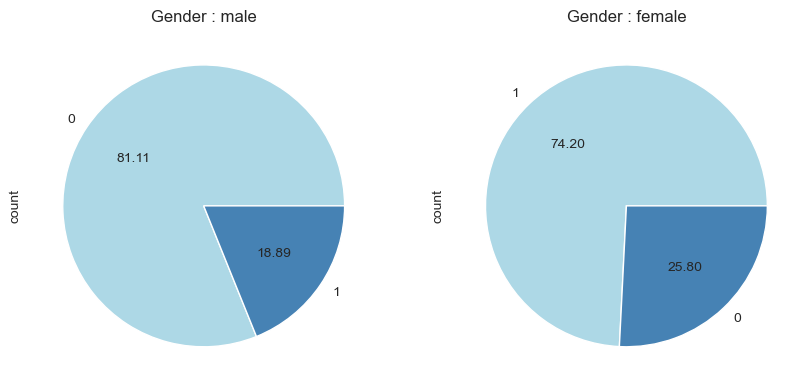

In [43]:
fig = plt.figure(figsize=(10,5))

i = 0
for gender in train_df['Sex'].unique():
    fig.add_subplot(1, 2, i+1)
    plt.title('Gender : {}'.format(gender))
    train_df.Survived[train_df['Sex'] == gender].value_counts().plot(kind='pie', autopct='%.2f', colors=['lightblue', 'steelblue'])
    i += 1

In [44]:
gender_mapping = {'male':0,
                  'female':1}

train_df['Sex'] = train_df['Sex'].apply(lambda x : gender_mapping.get(x)) 
entire_df['Sex'] = entire_df['Sex'].apply(lambda x : gender_mapping.get(x))

In [45]:
embark_mapping = {'S':0,
                  'Q':1,
                  'C':2}

train_df['Embarked'] = train_df['Embarked'].apply(lambda x : embark_mapping.get(x))
entire_df['Embarked'] = entire_df['Embarked'].apply(lambda x : embark_mapping.get(x))

In [46]:
title_mapping = {'Mr':0,
                 'Dr':1,
                 'Master':2,
                 'Miss':3,
                 'Mrs':4}

train_df['Title'] = train_df['Title'].apply(lambda x : title_mapping.get(x)) 
entire_df['Title'] = entire_df['Title'].apply(lambda x : title_mapping.get(x))

In [47]:
fam_mapping = {11:0,
               8:0,
               6:2,
               5:3,
               1:4,
               7:5,
               2:6,
               3:7,
               4:8}

train_df['Fam'] = train_df['Fam'].apply(lambda x : fam_mapping.get(x)) 
entire_df['Fam'] = entire_df['Fam'].apply(lambda x : fam_mapping.get(x))

In [48]:
from sklearn.preprocessing import OrdinalEncoder

features = ['Name', 'Ticket']

for feat in features:
    entire_df[feat] = OrdinalEncoder().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [49]:


features = ['Name', 'Pclass', 'Age', 'Sex', 'Fare', 'SibSp', 'Parch', 'Ticket','Embarked', 'Fam', 'Title']

for feat in features:
    entire_df[feat] = MinMaxScaler().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [52]:
entire_df.drop(['Cabin'], axis=1, inplace=True)

<Axes: >

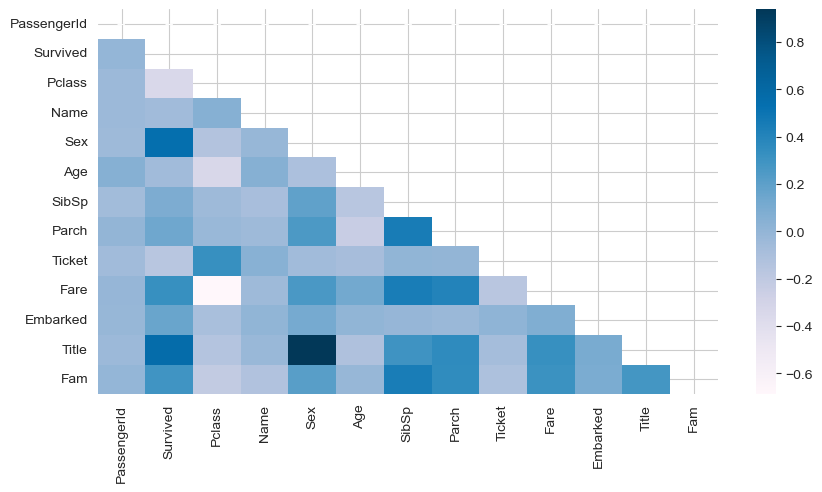

In [53]:
train_df = (entire_df.iloc[0:891]).copy()
corr_matrix = train_df.corr('spearman')
sns.heatmap(corr_matrix, cbar=True, annot=True,  mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), cmap='PuBu')

In [72]:
X = train_df.copy()
y = X.pop('Survived')

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)  


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB


# Create first pipeline for base 
from sklearn.pipeline import Pipeline
pipe = Pipeline([('classifier' , RandomForestClassifier(random_state=seed))])


# Get the best estimator via GridSearch
param_grid = [{'classifier' : [RandomForestClassifier(random_state=seed)],
               'classifier__max_depth' : np.arange(3, 20, 3),
               'classifier__min_samples_split' : np.arange(3, 20, 3),
               'classifier__min_samples_leaf' : np.arange(3, 20, 3)},
  
              {'classifier' : [LogisticRegression(random_state=seed, class_weight='balanced')],
               'classifier__penalty' : ['l1', 'l2'],
               'classifier__solver' : ['liblinear']},
           
              {'classifier' : [ComplementNB()],
               'classifier__alpha': [0.01, 0.1, 0.5, 1.0],
               'classifier__fit_prior': [True, False]}]


grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.833857 using {'classifier': RandomForestClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=15,
                       random_state=42), 'classifier__max_depth': 9, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 15}


In [73]:
# Re-train with the best estimator and parameters
rf_model = RandomForestClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=15, random_state=seed)
rf_model.fit(X_train, y_train)
rf_ypred = rf_model.predict(X_valid)

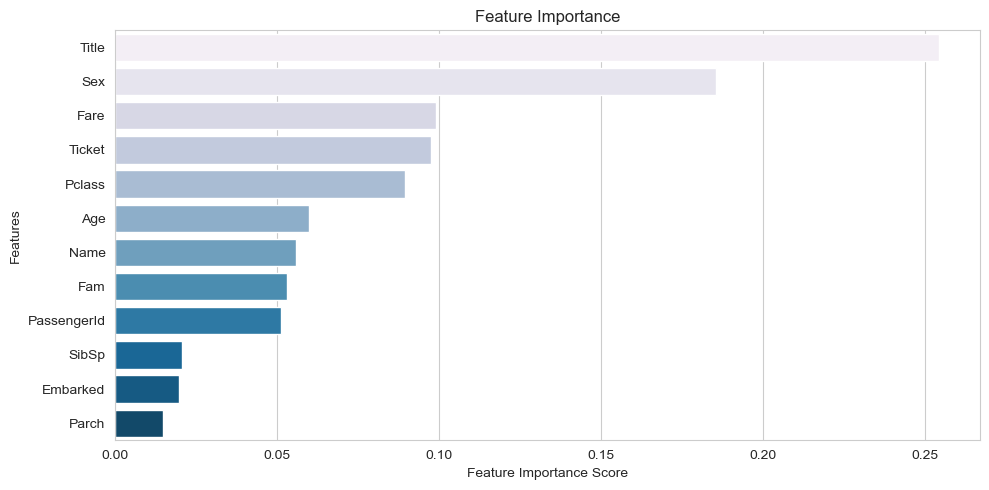

In [74]:
feature_imp = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index, palette='PuBu')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.tight_layout()

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       134
           1       0.84      0.74      0.79        89

    accuracy                           0.84       223
   macro avg       0.84      0.82      0.83       223
weighted avg       0.84      0.84      0.84       223

Confusion Matrix of Orginal model:


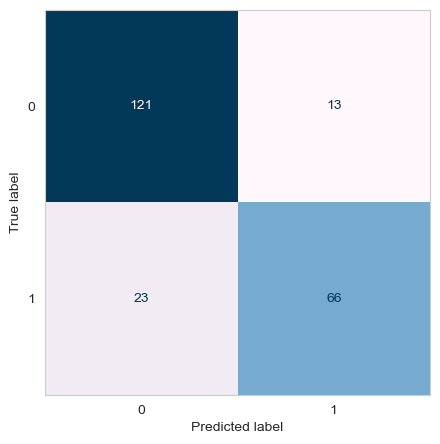

In [78]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_valid, rf_ypred))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(y_valid, rf_ypred, colorbar = False, cmap = 'PuBu')
plt.grid(False)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       134
           1       0.83      0.75      0.79        89

    accuracy                           0.84       223
   macro avg       0.84      0.82      0.83       223
weighted avg       0.84      0.84      0.84       223

Confusion Matrix of New model:


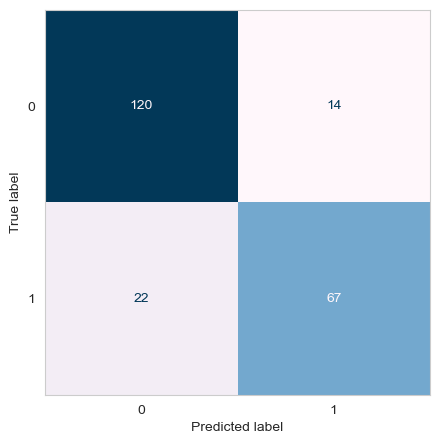

In [80]:
new_X_train = X_train.drop(['Parch', 'SibSp', 'Embarked'], axis=1)
new_X_valid = X_valid.drop(['Parch', 'SibSp', 'Embarked'], axis=1)

new_model = RandomForestClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=15, random_state=seed)
new_model.fit(new_X_train, y_train)
new_ypred = new_model.predict(new_X_valid)


print(classification_report(y_valid, new_ypred))
print('Confusion Matrix of New model:')
ConfusionMatrixDisplay.from_predictions(y_valid, new_ypred, colorbar = False, cmap = 'PuBu')
plt.grid(False)

In [81]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)


fold_no = 1
for trn_idx,tst_idx in skf.split(X, y):
    trn = train_df.iloc[trn_idx,:]
    tst = train_df.iloc[tst_idx,:]
    x_trn = trn.drop(['Survived', 'Parch', 'SibSp', 'Embarked'],axis=1)
    y_trn = trn['Survived']
    x_tst = tst.drop(['Survived', 'Parch', 'SibSp', 'Embarked'],axis=1)
    y_tst = tst['Survived']
    model = RandomForestClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=15, random_state=seed)
    model.fit(x_trn, y_trn)
    score = model.score(x_tst,y_tst)
    print('For Fold {} the accuracy is {:.2f}'.format(str(fold_no),score))
    avg_score = score.mean()
    fold_no += 1
    
print('\nAverage stratified k-fold cross-validation: {:.2f}'.format(avg_score))

For Fold 1 the accuracy is 0.86
For Fold 2 the accuracy is 0.85
For Fold 3 the accuracy is 0.83
For Fold 4 the accuracy is 0.83
For Fold 5 the accuracy is 0.85

Average stratified k-fold cross-validation: 0.85


In [86]:
test_df = (entire_df.iloc[891:]).copy()
test_df = test_df.drop(['Survived', 'Parch', 'SibSp', 'Embarked'], axis=1)

prediction = new_model.predict(test_df)

submission = pd.DataFrame(test_df['PassengerId'], columns=['PassengerId'])
submission['Survived'] = prediction

submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB


Random Forest:
  Accuracy (Train): 100.00%
  Accuracy (Test): 84.30%
  Log Loss (Train): 0.1039
  Log Loss (Test): 0.5455
--------------------------------------------------
SGD:
  Accuracy (Train): 38.62%
  Accuracy (Test): 40.81%
  Log Loss (Train): 22.1226
  Log Loss (Test): 21.3353
--------------------------------------------------
Linear SVC:
  Accuracy (Train): 73.95%
  Accuracy (Test): 77.58%
  Log Loss (Train): 8.7977
  Log Loss (Test): 7.4448
--------------------------------------------------
KNN:
  Accuracy (Train): 71.56%
  Accuracy (Test): 59.19%
  Log Loss (Train): 0.5488
  Log Loss (Test): 1.3272
--------------------------------------------------
Gaussian Naive Bayes:
  Accuracy (Train): 80.69%
  Accuracy (Test): 80.27%
  Log Loss (Train): 0.7692
  Log Loss (Test): 0.8834
--------------------------------------------------
SVC:
  Accuracy (Train): 62.13%
  Accuracy (Test): 60.09%
  Log Loss (Train): 0.4848
  Log Loss (Test): 0.5194
------------------------------------------

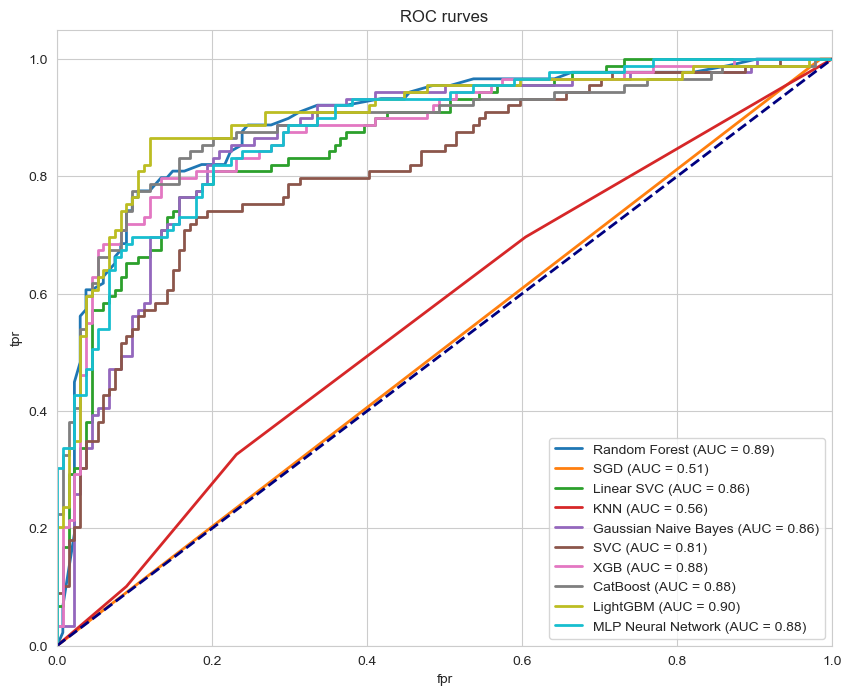

In [69]:
class ModelEvaluator:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.models = [
            ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
                        ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

    def calculate_log_loss(self, model):
        if hasattr(model, "predict_proba"):
            probas_train = model.predict_proba(self.X_train)
            probas_test = model.predict_proba(self.X_test)
        else:
            probas_train = model.decision_function(self.X_train)
            probas_test = model.decision_function(self.X_test)

        log_loss_train = log_loss(self.Y_train, probas_train)
        log_loss_test = log_loss(self.Y_test, probas_test)
        return log_loss_train, log_loss_test


    def train_and_evaluate_models(self):
        for name, model in self.models:
            model.fit(self.X_train, self.Y_train)
            
            # Accuracy
            acc_train = accuracy_score(self.Y_train, model.predict(self.X_train)) * 100
            acc_test = accuracy_score(self.Y_test, model.predict(self.X_test)) * 100
            
            # Log Loss
            log_loss_train, log_loss_test = self.calculate_log_loss(model)
            
            # Print results
            print(f"{name}:")
            print(f"  Accuracy (Train): {acc_train:.2f}%")
            print(f"  Accuracy (Test): {acc_test:.2f}%")
            print(f"  Log Loss (Train): {log_loss_train:.4f}")
            print(f"  Log Loss (Test): {log_loss_test:.4f}")
            print("-" * 50)
        
    

    def plot_roc_curve(self):
        plt.figure(figsize=(10, 8))

        for name, model in self.models:
            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(self.X_test)[:, 1]
            else:
                probas_ = model.decision_function(self.X_test)

            fpr, tpr, _ = roc_curve(self.Y_test, probas_)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        # random roc to compare
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC rurves')
        plt.legend(loc="lower right")
        plt.show()


evaluator = ModelEvaluator(X_train, Y_train, X_test, Y_test)
evaluator.train_and_evaluate_models()
evaluator.plot_roc_curve()

KNeighborsClassifier()

In [71]:

models = [
 ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
            ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

def calculate_log_loss(self, model):
    if hasattr(model, "predict_proba"):
        probas_train = model.predict_proba(X_train)
        probas_test = model.predict_proba(X_test)
    else:
        probas_train = model.decision_function(X_train)
        probas_test = model.decision_function(X_test)

    log_loss_train = log_loss(Y_train, probas_train)
    log_loss_test = log_loss(Y_test, probas_test)
    return log_loss_train, log_loss_test

# Initialize lists to store the metrics
precision_train_list = []
precision_test_list = []
recall_train_list = []
recall_test_list = []
f1_train_list = []
f1_test_list = []
roc_auc_train_list = []
roc_auc_test_list = []
model_names = []
acc_train_list = []
acc_test_list = []
log_loss_train_list = []
log_loss_test_list = []

# Iterate through models and compute metrics
for name, model in models:
    try:
        model.fit(X_train, Y_train)
        
        # Accuracy
        acc_train = accuracy_score(Y_train, model.predict(X_train)) * 100
        acc_test = accuracy_score(Y_test, model.predict(X_test)) * 100
        
        # Log Loss
        log_loss_train, log_loss_test = calculate_log_loss(model, X_train, Y_train, X_test, Y_test)
        
        # Precision
        precision_train = precision_score(Y_train, model.predict(X_train))
        precision_test = precision_score(Y_test, model.predict(X_test))
        
        # Recall
        recall_train = recall_score(Y_train, model.predict(X_train))
        recall_test = recall_score(Y_test, model.predict(X_test))
        
        # F1-Score
        f1_train = f1_score(Y_train, model.predict(X_train))
        f1_test = f1_score(Y_test, model.predict(X_test))
        
        # ROC AUC
        if hasattr(model, "predict_proba"):
            roc_auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
            roc_auc_test = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
        else:
            roc_auc_train = roc_auc_score(Y_train, model.decision_function(X_train))
            roc_auc_test = roc_auc_score(Y_test, model.decision_function(X_test))
        
        # Append the model name and metrics to the lists
        model_names.append(name)
        precision_train_list.append(precision_train)
        precision_test_list.append(precision_test)
        recall_train_list.append(recall_train)
        recall_test_list.append(recall_test)
        f1_train_list.append(f1_train)
        f1_test_list.append(f1_test)
        roc_auc_train_list.append(roc_auc_train)
        roc_auc_test_list.append(roc_auc_test)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        log_loss_train_list.append(log_loss_train)
        log_loss_test_list.append(log_loss_test)
        
    except Exception as e:
        # In case of any error, append np.nan or a default value
        print(f"Error with model {name}: {e}")
        model_names.append(name)
        precision_train_list.append(np.nan)
        precision_test_list.append(np.nan)
        recall_train_list.append(np.nan)
        recall_test_list.append(np.nan)
        f1_train_list.append(np.nan)
        f1_test_list.append(np.nan)
        roc_auc_train_list.append(np.nan)
        roc_auc_test_list.append(np.nan)
        
        acc_train_list.append(np.nan)
        acc_test_list.append(np.nan)
        log_loss_train_list.append(np.nan)
        log_loss_test_list.append(np.nan)

# Create DataFrame for model comparison
models_comparison = pd.DataFrame({
    'Model': model_names,
    'Score_train': acc_train_list,
    'Score_test': acc_test_list,
    'LogLoss_train': log_loss_train_list,
    'LogLoss_test': log_loss_test_list,
    'Precision_train': precision_train_list,
    'Precision_test': precision_test_list,
    'Recall_train': recall_train_list,
    'Recall_test': recall_test_list,
    'F1_train': f1_train_list,
    'F1_test': f1_test_list,
    'ROC_AUC_train': roc_auc_train_list,
    'ROC_AUC_test': roc_auc_test_list
})

# Sort the models by test accuracy
models_comparison = models_comparison.sort_values(by='Score_test', ascending=False)
models_comparison






Error with model Random Forest: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model SGD: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model Linear SVC: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model KNN: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model Gaussian Naive Bayes: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model SVC: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model XGB: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model CatBoost: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model LightGBM: calculate_log_loss() takes 2 positional arguments but 5 were given
Error with model MLP Neural Network: calculate_log_loss() takes 2 positional arguments but 5 were given


,Model,Score_train,Score_test,LogLoss_train,LogLoss_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,ROC_AUC_train,ROC_AUC_test
0,Random Forest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SGD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Linear SVC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gaussian Naive Bayes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,SVC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,XGB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CatBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LightGBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MLP Neural Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
import optuna

In [209]:
##catboost validation + optuna
X_train_split, X_eval, Y_train_split, Y_eval = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 2, 7),
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 10),
    }


    model = CatBoostClassifier(**param, verbose=0)


    model.fit(X_train_split, Y_train_split, eval_set=(X_eval, Y_eval), early_stopping_rounds=50)


    y_pred_proba = model.predict_proba(X_test) 


    loss = log_loss(Y_test, y_pred_proba)
    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best hyperparameters:', study.best_params)
print('Best log_loss:', study.best_value)


best_params = study.best_params
final_model = CatBoostClassifier(**best_params, verbose=0)
final_model.fit(X_train, Y_train)


predictions = final_model.predict(X_test)
print("Predictions on test dataset:", predictions)


vis.plot_param_importances(study)

[I 2024-12-04 23:31:35,471] A new study created in memory with name: no-name-1d8a99c7-daee-4a2a-ba95-12ac89ccf178


[I 2024-12-04 23:31:35,661] Trial 0 finished with value: 0.3392371974685728 and parameters: {'learning_rate': 0.27294957774620243, 'depth': 6, 'iterations': 781, 'reg_lambda': 3.130919849628908}. Best is trial 0 with value: 0.3392371974685728.
[I 2024-12-04 23:31:36,220] Trial 1 finished with value: 0.3271993390970891 and parameters: {'learning_rate': 0.011444284987167357, 'depth': 5, 'iterations': 1167, 'reg_lambda': 1.383627773815983}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:36,401] Trial 2 finished with value: 0.35385351406016624 and parameters: {'learning_rate': 0.24215885958400366, 'depth': 4, 'iterations': 627, 'reg_lambda': 8.728587391354395}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:36,557] Trial 3 finished with value: 0.357026024798522 and parameters: {'learning_rate': 0.13831164417100594, 'depth': 4, 'iterations': 1952, 'reg_lambda': 1.6438906376558426}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:

Best hyperparameters: {'learning_rate': 0.2014577786654323, 'depth': 7, 'iterations': 1015, 'reg_lambda': 9.683956200134041}
Best log_loss: 0.3046558830988605
Predictions on test dataset: [1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1]


In [404]:


def objective(trial):
    # Определяем гиперпараметры для XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Количество деревьев
        'max_depth': trial.suggest_int('max_depth', 2, 5),  # Максимальная глубина дерева
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Темп обучения
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Пропорция данных для обучения
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Пропорция признаков для каждого дерева
        'gamma': trial.suggest_float('gamma', 0, 10),  # Регуляризация по величине разницы
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # Регуляризация L2
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # Регуляризация L1
    }

    # Создание модели с выбранными гиперпараметрами
    model = xgb.XGBClassifier(**param, random_state=42)

    # Используем кросс-валидацию для оценки модели
    f1_scores = cross_val_score(model, X_train, Y_train, scoring='f1', cv=5)  # 5-фолд кросс-валидация

    # Возвращаем среднее значение F1-score
    return 1 - np.mean(f1_scores)  # Мы минимизируем значение, поэтому возвращаем 1 - F1

# Создание объекта исследования
study = optuna.create_study(direction='minimize')  # Мы минимизируем 1 - F1, что эквивалентно максимизации F1
study.optimize(objective, n_trials=500)

print('Best hyperparameters:', study.best_params)
print('Best F1 score:', 1 - study.best_value)

# Извлекаем лучшие гиперпараметры и обучаем финальную модель
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, Y_train)

# Прогнозируем на тестовой выборке
predictions = final_model.predict(X_test)
print("Predictions on test dataset:", predictions)

# Отображаем важность параметров
optuna.visualization.plot_param_importances(study)


[I 2024-12-05 11:08:15,243] A new study created in memory with name: no-name-b050a841-d0d5-49b7-89d9-dcdc7014fa5a
[I 2024-12-05 11:08:15,979] Trial 0 finished with value: 0.2485605625267734 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.08978211909410559, 'subsample': 0.7906814172870996, 'colsample_bytree': 0.7983927642002047, 'gamma': 8.340511650823208, 'reg_lambda': 6.136555733862428, 'reg_alpha': 3.7780208690281336}. Best is trial 0 with value: 0.2485605625267734.
[I 2024-12-05 11:08:16,577] Trial 1 finished with value: 0.2485605625267734 and parameters: {'n_estimators': 179, 'max_depth': 5, 'learning_rate': 0.1558211233953881, 'subsample': 0.8407784146355031, 'colsample_bytree': 0.6832342909800707, 'gamma': 7.827694309031287, 'reg_lambda': 7.312108003049019, 'reg_alpha': 1.8497914334931953}. Best is trial 0 with value: 0.2485605625267734.
[I 2024-12-05 11:08:16,773] Trial 2 finished with value: 0.2547261141468704 and parameters: {'n_estimators': 108, 'max_

Best hyperparameters: {'n_estimators': 360, 'max_depth': 5, 'learning_rate': 0.1455428835432411, 'subsample': 0.975290327166701, 'colsample_bytree': 0.935881038812509, 'gamma': 6.438280950103595, 'reg_lambda': 1.3017731085696718, 'reg_alpha': 0.21682691499698006}
Best F1 score: 0.7824965408228199
Predictions on test dataset: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 

Using 891 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/418 [00:00<?, ?it/s]

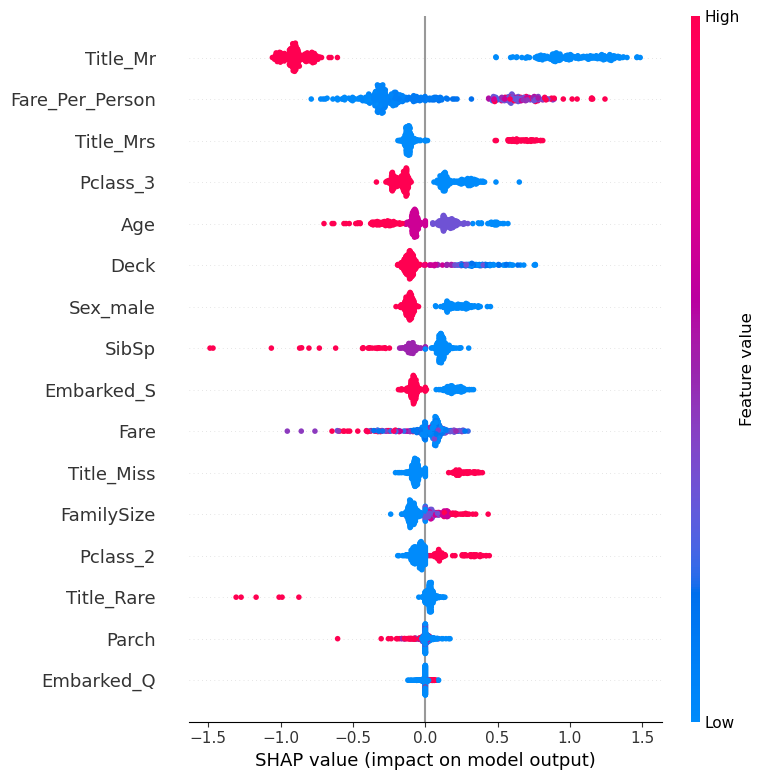

In [919]:
explainer = shap.KernelExplainer(final_model.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)  
shap.summary_plot(shap_values[1], X_test)

In [85]:
submission = pd.DataFrame({
        "PassengerId": pd.read_csv('test.csv')['PassengerId'],
        "Survived": prediction
    })
submission.to_csv('submission_last_rfm.csv', index=False)

In [87]:
submission.to_csv('submission_last_rfm_2.csv', index=False)

In [406]:
y_pred =  final_model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, models[6][1].predict(x_test)))
print(log_loss(y_test, models[6][1].predict_proba(x_test)[:, 1]))

0.8325358851674641
0.4173003927154396


In [407]:
print(accuracy_score(Y_test,y_pred))
print(f1_score(Y_test, y_pred))


0.9641148325358851
0.9498327759197324
